# Bias-Variance

... on going ...

by reading a few papers [cite] the methodology is as follows...

The Loss of a Algorithm (not of a model!) can be decomposed in:
$$L(A) = Bias(A) + Variance(A) + Noise(A)$$
where:
 - Bias is how far is the model from the prediction
 - Variance is how sensitive (how changes) the prediction with different training sets (overfitting)
 - Noise is the irreducible error in the dataset (learner independent)

Given a dataset $D$, given a number of iteration $l$, we need to produce $l$ score predictions
for each element in $D$ with $l$ different models. If the loss function $L$ is MSE then everything is clear.
If the loss function is NDCG, no previous work.

  0. Shuffle $D$ and create two halves $D_1$ and $D_2$ (this should be query-aware with NDCG)
  0. learn a model from $D_1$ and apply it to $D_2$
  0. learn a model from $D_2$ and apply it to $D_1$
  0. store the scores produced so far
  0. Repeat all of the above $l$ times
  0. for each document/query compute the average prediction by averagin the $l$ stored so far (for ranking this is actually not defined, we may average predictions and then rank accordingly)
  0. Bias of a query/document is computed as the loss between the ideal prediction and the average prediction
  0. Average above for every query/document to obtain final Bias
  0. Variance of a query/document is computed as the average loss between the average prediction and every of the $l$ predictions
  0. Average above for every query/document to obtain final Variance
 
Usually Noise is assumed to be 0 as it is impossible to estimated it.
As a consequence, ometimes Variance is defined as $L(A)-Bias(A)$.

In every work, $L(A)$ should be equal to $Bias(A) + Variance(A)$. Is this true for NDCG? probably not ...

In principle, we may provide just the Loss and the Bias, and let the user compute variance by difference.

We might probalby solve the ranking problem, by saying that L is not 1-NDCG, but rather (1-NDCG)^2

In [1]:
from rankeval.core.dataset import Dataset
from rankeval.core.metrics import NDCG
from rankeval.core.metrics.rmse import RMSE
from rankeval.core.metrics.metric import Metric
import numpy as np
import math
import lightgbm
from __future__ import print_function

%matplotlib inline
from matplotlib import pyplot as plt

In [2]:
dataset = Dataset.load("/Users/claudio/docs/LAVORO/coding/ltr/QuickScorer/debug_data/msn1.fold1.test.5k.txt", name="msn1")

In [15]:
def lgbm_algo(train_X, train_Y, train_q, test_X):
    params = {'num_leaves': 128, 'objective':'lambdarank',
             'learning_rate': 0.01, 'max_bin': 1024}

    training = lightgbm.Dataset(data=train_X, label=train_Y, group=train_q)
    
    bst = lightgbm.train(params, training, num_boost_round=10)
    
    # check the number of trees and other params is correct
    # print ( len(bst.dump_model()[u'tree_info']) )
    
    return bst.predict(test_X)


def kfold_scoring(dataset, k, algo, verbose=False):
    scores = np.zeros(dataset.n_instances, dtype=np.float32)
    q_lens = dataset.query_ids[1:]-dataset.query_ids[:-1]
    # shuffle queries
    shuffled_qid = np.random.permutation(dataset.n_queries)
    chunk_size = int(math.ceil(dataset.n_queries/float(k)))
    for f,p in enumerate(range(0,dataset.n_queries,chunk_size)):
        if verbose: print (" - Processing fold", f, "of", k)
        # p-th fold is used for testing
        test_rows = np.zeros(dataset.n_instances, dtype=np.bool)
        for q in shuffled_qid[p: p+chunk_size]:
            test_rows[ dataset.query_ids[q]:dataset.query_ids[q+1] ] = True
        # other folds are used for training
        train_rows = np.logical_not(test_rows)
        train_q = np.ones(dataset.n_queries, dtype=np.bool)
        train_q[shuffled_qid[p: p+chunk_size]] = False
        # get algorithm predictions
        fold_scores = algo(dataset.X[train_rows], dataset.y[train_rows], q_lens[train_q],
                           dataset.X[test_rows])
        # update scores for the current fold
        scores[test_rows] = fold_scores
        
    return scores
            
def multi_kfold_scoring(dataset, algo, L=10, k=2):
    scores = np.zeros( (dataset.n_instances, L), dtype=np.float32)

    for l in range(L):
        print (" + Dataset scoring", l, "of", L)
        scores[:,l] = kfold_scoring(dataset, k, algo)
        # remove this
        assert len(np.where(scores[:,l]==0)[0]) == 0
    
    return scores

def bias_variance(dataset, algo, metric="mse", L=10, k=2):
    if isinstance(metric, str):
        assert metric=="mse"
    else:
        assert isinstance(metric, Metric)
        
    scores = multi_kfold_scoring(dataset, algo=algo, L=L, k=5)
    
    avg_error = 0.
    avg_bias = 0.
    avg_var = 0.
    if isinstance(metric, Metric):
        # mse over metric
        # not exactly domingos paper
        q_scores = np.empty((dataset.n_queries, L), dtype=np.float32) 
        for i in range(L):
            q_scores[:,i] = metric.eval(dataset=dataset, y_pred=scores[:,i])[1]            
        avg_error = np.mean( (q_scores-1.)**2. )
        avg_pred  = np.mean(q_scores, axis=1)
        avg_bias  = np.mean((avg_pred - 1.)**2.)
        avg_var   = np.mean( (q_scores-avg_pred.reshape((-1,1)))**2. )
        
        plt.figure()
        plt.matshow(q_scores)
    else:
        # mse
        avg_error = np.mean( (scores-dataset.y.reshape((-1,1)))**2. )
        avg_pred  = np.mean(scores, axis=1)
        avg_bias  = np.mean((avg_pred - dataset.y)**2.)
        avg_var   = np.mean( (scores-avg_pred.reshape((-1,1)))**2. )
    
    return avg_error, avg_bias, avg_var

    


 + Dataset scoring 0 of 10
 + Dataset scoring 1 of 10
 + Dataset scoring 2 of 10
 + Dataset scoring 3 of 10
 + Dataset scoring 4 of 10
 + Dataset scoring 5 of 10
 + Dataset scoring 6 of 10
 + Dataset scoring 7 of 10
 + Dataset scoring 8 of 10
 + Dataset scoring 9 of 10


(0.42298207, 0.41451901, 0.0084630894)

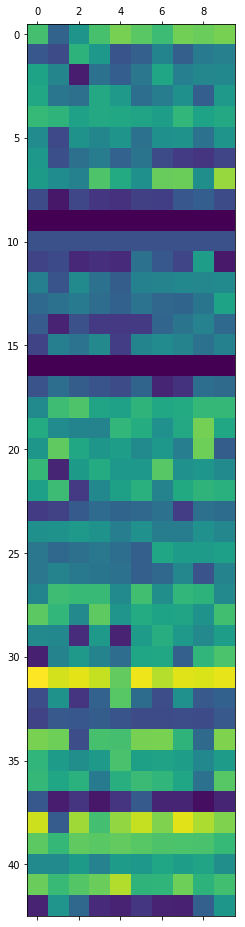

In [14]:
bias_variance(dataset, algo=lgbm_algo, metric=NDCG(cutoff=10), L=10, k=2)

 + Dataset scoring 0 of 10
 + Dataset scoring 1 of 10
 + Dataset scoring 2 of 10
 + Dataset scoring 3 of 10
 + Dataset scoring 4 of 10
 + Dataset scoring 5 of 10
 + Dataset scoring 6 of 10
 + Dataset scoring 7 of 10
 + Dataset scoring 8 of 10
 + Dataset scoring 9 of 10


(0.44634604, 0.43431166, 0.012034399)

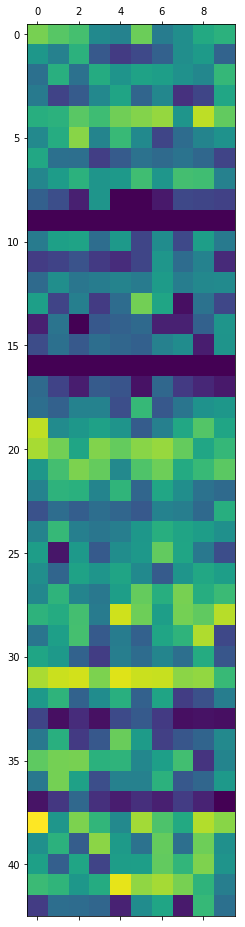

In [16]:
bias_variance(dataset, algo=lgbm_algo, metric=NDCG(cutoff=10), L=10, k=2)

In [20]:
scores = kfold_scoring(dataset, 2, lgbm_algo)
NDCG(cutoff=10).eval(dataset, scores)[0]
(1.-NDCG(cutoff=10).eval(dataset, scores)[0])**2

0.46499739800515272